In [204]:
import numpy as np
from scipy.integrate import *
from numpy.fft import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [205]:
  d=1 #"rugóállandó"
  m=1 #tömegek
  R=1 #"kör" sugara
  rho=1.1 #külső kör sugara
  k=0.3 #külső kölcsönhatás

In [206]:
params=(d,m,R,rho,k)

In [207]:
def diffeq(X,t, params):
  """
  A modell: R sugarú körön egyenletesen elrendezett golyók összekötve valamilyen rugóval.
  Körülöttük egy másik golyó halad.

  Bemenetnek kapja egy array-ben:
  - kezdeti szögeket (belső és külső)
  - kezdeti szögsebességeket

  Külön pedig néhány paramétert (sorban):
  - rugóállandó (d)
  - tömegek (m)
  - kör sugara (R)
  - külső kör sugara (rho)
  - külső kölcsönhatás (k)
  """

  N=int((len(X)-2)/2)
  d,m,R,rho,k=params  #bejövő paraméterek
  l=2*R*np.sin(np.pi/N) #rugók nyugalmi hossza

  phi = np.array(X[:N]) #első N darab elem a szögek
  omega = np.array(X[N:2*N])  #második N darab a szögsebességek
  theta = np.array([X[-2]]) #utolsó előtti elem a kezdeti szög
  Omega = np.array([X[-1]]) #utolsó a szögsebessége

  phi_m1 = np.roll(phi,-1)
  phi_p1 = np.roll(phi,1)

  #belső golyók szöggyorsulása:
  beta = (1/(m*R)) * (-1) * d * ( R * np.sin(phi-phi_m1) -
                                  R * np.sin(phi_p1-phi) -
                                  l * np.cos((phi+phi_m1)/2) +
                                  l * np.cos((phi_p1+phi)/2) +
                                  (1/d) * rho * k * np.exp( -np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2))*np.sin(theta - phi)
                                  / np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2 )
                                  )

  #külső golyó szöggyorsulása:
  Beta = np.array([(1/(m*R)) * R * k * np.sum(np.exp( -np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2))*np.sin(theta - phi)
                                  / np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2 ))])

  U = np.concatenate((omega, beta, Omega, Beta))

  return U

In [208]:
n=100 #golyók száma
s=200 #időfelosztás
T=200 #vizsgált időintervallum

In [209]:
t=np.linspace(0,T,s)

In [210]:
phi_0=np.linspace(0,2*np.pi,n)

omega_0=np.zeros(n)
omega_0[0]=0

theta=np.array([0])
Omega=np.array([np.pi])

X_0=np.concatenate((phi_0,omega_0,theta, Omega))

In [211]:
u=odeint(diffeq,X_0,t,args=(params,))
#diffegy megoldása

In [212]:
phi=u[:,:n]
omega=u[:,n:2*n]
theta=u[:,-2]
Omega=u[:,-1]
#A megoldás szétbontva

Text(0.5, 1.0, 'A szögsebességek alakulása')

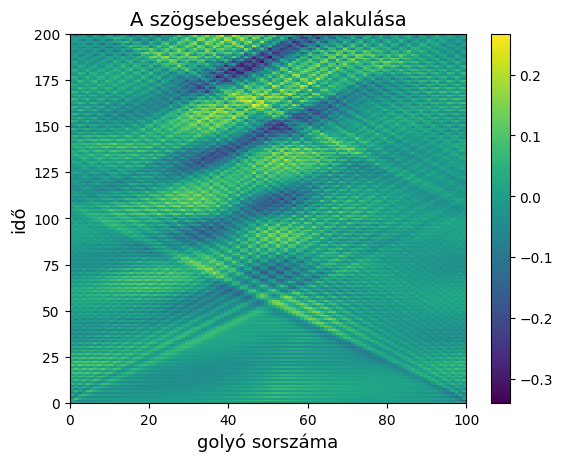

In [213]:
plt.pcolormesh(omega)
plt.colorbar()
plt.ylabel('idő', size=13)
plt.xlabel('golyó sorszáma', size=13)
plt.title('A szögsebességek alakulása', size=14)

Text(0.5, 1.0, 'A külső golyó körfrekvenciájának alakulása')

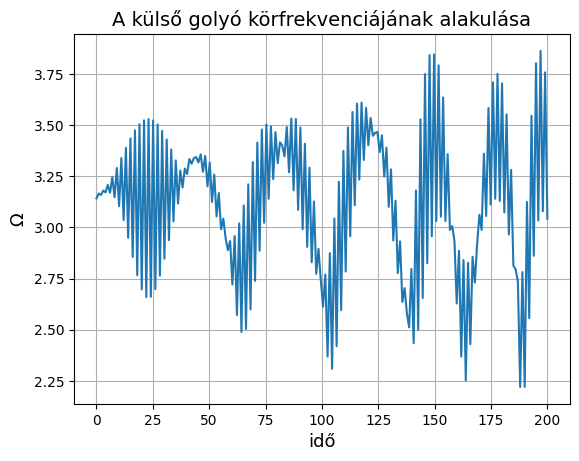

In [214]:
plt.plot(t,Omega)
plt.grid()
plt.ylabel(r'$\Omega$ ', size=13)
plt.xlabel('idő', size=13)
plt.title('A külső golyó körfrekvenciájának alakulása', size=14)

In [215]:
E_kin_kulso= 1/2 * m * rho**2 * Omega**2

Text(0.5, 1.0, 'A külső golyó mozgási energiájának alakulása')

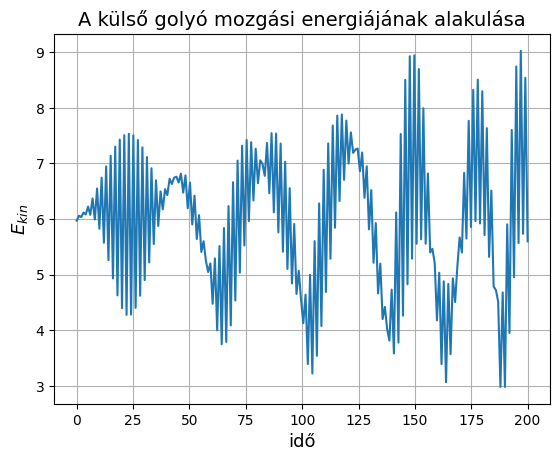

In [216]:
plt.plot(t, E_kin_kulso)
plt.grid()
plt.ylabel(r'$E_{kin}$ ', size=13)
plt.xlabel('idő', size=13)
plt.title('A külső golyó mozgási energiájának alakulása', size=14)

In [217]:
v=R*omega

In [218]:
v_fft=np.abs(fft(ifft(v, axis=0),axis=1))
w=(fftfreq(len(t),t[1]-t[0]))
q=fftfreq(v.shape[1],1)

Text(0.5, 1.0, 'A sebesség FFT-ja')

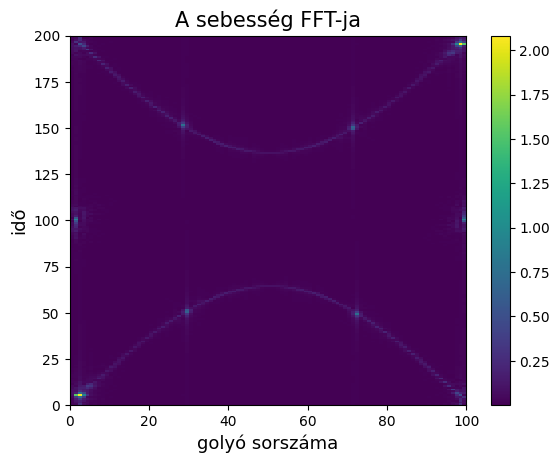

In [219]:
plt.pcolormesh(v_fft)

plt.colorbar()
plt.xlabel('golyó sorszáma',size=13)
plt.ylabel('idő',size=13)
plt.title('A sebesség FFT-ja',size=15)

In [220]:
#fig, axs = plt.subplots(figsize=(4, 5))
#plt.pcolormesh(q,np.abs(w),v_fft)
#plt.colorbar()
#plt.ylabel(r'$\omega$ körfrekvencia', size=13)
#plt.xlabel(r'$k$ hullámszám', size=13)
#plt.title(r'$\omega (k)$', size=14)

Text(0.5, 1.0, '$\\omega (k)$')

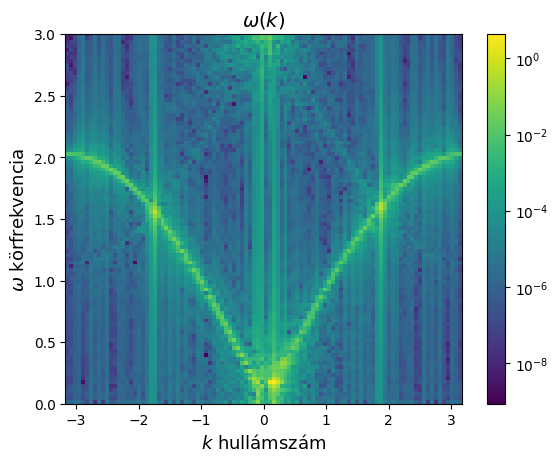

In [221]:
kran = np.linspace(-np.pi, np.pi, n)
wran = np.linspace(-np.pi/np.diff(t)[0],np.pi/np.diff(t)[0], len(t))
plt.pcolormesh(kran, wran, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fft(v, axis=1),axis=0), axes=(1,0)))**2, norm=LogNorm())

plt.ylim(0,3)
plt.colorbar()
plt.ylabel(r'$\omega$ körfrekvencia', size=13)
plt.xlabel(r'$k$ hullámszám', size=13)
plt.title(r'$\omega (k)$', size=14)

In [222]:
V=np.zeros((s,n))
for i in range(n):
  V[:,i]=k*np.exp(
      (-1)*(np.sqrt(R**2 + rho**2 - 2*R*rho*np.cos(theta[:]-phi[:,i])))
      )

(0.0, 10.0)

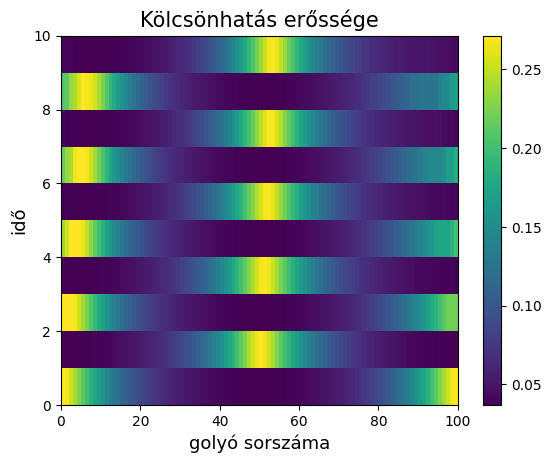

In [223]:
plt.pcolormesh(V)
plt.colorbar()
plt.xlabel('golyó sorszáma',size=13)
plt.ylabel('idő',size=13)
plt.title('Kölcsönhatás erőssége',size=15)
plt.ylim(0,10)